In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Imaging
import imageio.v2 as imageio
from matplotlib.colors import ListedColormap

# Default year range
years = range(2015, 2016)

file_type = "png"
# data_folder = "png"
data_folder = "png_no_labels"
# file_type = "npy"
# data_folder = "npy"
use_existing_npy = False

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(gpus))
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


In [3]:
def get_path(parts):
    out_path = ""
    for part in parts:
        out_path = out_path + f"{part}{os.path.sep}"

    out_path = out_path.rstrip(os.path.sep)
    return out_path

## Example npy file

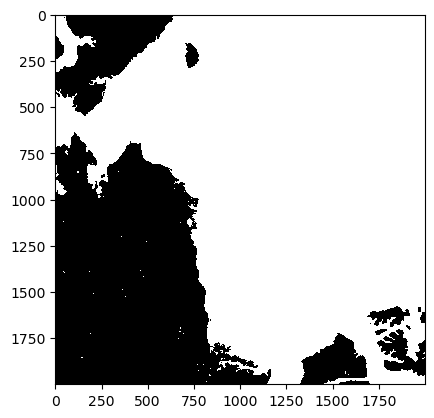

npy shape (2000, 2000)


In [4]:
colors = ["#000000", "#FFFFFF"]
cmap = ListedColormap(colors, name="binary_map", N=len(colors))

array_2D = np.load(
    r"D:\IceDyno\IMS_images_converted\2015\npy\ims2015001_1km_v1_grid1000.npy"
)
plt.imshow(array_2D, cmap=cmap)
plt.show()

print(f"npy shape {array_2D.shape}")

## Example png file

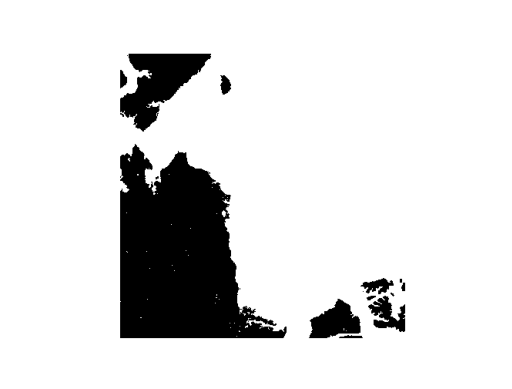

png shape (480, 640, 4)


In [5]:
colors = ["#000000", "#FFFFFF"]
cmap = ListedColormap(colors, name="binary_map", N=len(colors))

array_2D = imageio.imread(
    r"D:\IceDyno\IMS_images_converted\2015\png_no_labels\ims2015001_1km_v1_grid1000.png"
)
plt.imshow(array_2D, cmap=cmap)
plt.axis("off")
plt.show()

print(f"png shape {array_2D.shape}")

## Load npy or png files

In [6]:
%%time
npy_file = get_path(["D:", "IceDyno", "IMS_images_converted", "all_data.npy"])
dfs = []

if os.path.exists(npy_file) and use_existing_npy:
    ims_dataset = np.load(npy_file)
else:
    ims_dataset = []
    for yr in years:
        print(f"Loading year: {yr}")
        root_dir = get_path(["D:\IceDyno", "IMS_images_converted", yr, data_folder])
        file_list = glob.glob(get_path([root_dir, f"*.{file_type}"]))
        for data_file in file_list:
            if file_type == "png":
                ims_data_today = imageio.imread(data_file)
            else:
                ims_data_today = np.load(data_file)
            ims_data_today_flattened = ims_data_today.flatten()
            ims_dataset.append(ims_data_today_flattened)

        csv_filename = get_path(
            ["D:\IceDyno", "IMS_images_converted", yr, "image_dates.csv"]
        )
        if os.path.exists(csv_filename):
            df = pd.read_csv(csv_filename, index_col=False)
            dfs.append(df)

    ims_dataset = np.array(ims_dataset)

    np.save(npy_file, ims_dataset)

# Set dataframe that holds indices for image dates
df = pd.concat(dfs, ignore_index=True)

# Create scaled dataset from input
scaled_dataset = ims_dataset / 255.0
ims_dataset = []  # Free memory
scaled_dataset.shape

Loading year: 2015


,File Name,Date
0,ims2015001_1km_v1.3.nc,2015-01-01
1,ims2015002_1km_v1.3.nc,2015-01-02
2,ims2015003_1km_v1.3.nc,2015-01-03
3,ims2015004_1km_v1.3.nc,2015-01-04
4,ims2015005_1km_v1.3.nc,2015-01-05
...,...,...
359,ims2015361_1km_v1.3.nc,2015-12-27
360,ims2015362_1km_v1.3.nc,2015-12-28
361,ims2015363_1km_v1.3.nc,2015-12-29
362,ims2015364_1km_v1.3.nc,2015-12-30


CPU times: total: 1.91 s
Wall time: 3.24 s


(364, 1228800)

## Create train/val/train

In [7]:
train_size = int(len(scaled_dataset) * 0.7)
val_size = int(len(scaled_dataset) * 0.2)
test_size = int(len(scaled_dataset) * 0.1)

train = scaled_dataset[:train_size]
val = scaled_dataset[train_size : train_size + val_size]
test = scaled_dataset[train_size + val_size :]

scaled_dataset = []  # Free memory
print(
    f"Size of train: {len(train)}\nSize of validation: {len(val)}\nSize of test: {len(test)}"
)

Size of train: 254
Size of validation: 72
Size of test: 38


## Create time series with lookback = 1

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [9]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

print(f"train X: {trainX.shape}\ttrain Y: {trainY.shape}")
print(f"val X: {valX.shape}\tval Y: {valY.shape}")
print(f"test X: {testX.shape}\ttest Y: {testY.shape}")

train X: (252, 1, 1228800)	train Y: (252, 1228800)
val X: (70, 1, 1228800)	val Y: (70, 1228800)
test X: (36, 1, 1228800)	test Y: (36, 1228800)


In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))
print(
    f"reshaped train X: {trainX.shape}\nreshaped val X: {valX.shape}\nreshaped test X: {testX.shape}"
)

reshaped train X: (252, 1, 1228800)
reshaped val X: (70, 1, 1228800)
reshaped test X: (36, 1, 1228800)


## Build Conv LSTM model and train

In [11]:
%%time
"""
create and fit the LSTM network
run on CPU due to limitations of GPU memory
`mirroredstrategy` will still feed operations to GPU (if available)
"""

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, trainX.shape[2])))
    model.add(Dense(trainX.shape[2]))

    model.compile(loss="mean_squared_error", optimizer="adam")

early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1)
with tf.device("/CPU:0"):
    model.fit(
        trainX,
        trainY,
        epochs=100,
        batch_size=1,
        verbose=2,
        callbacks=[early_stopping],
        validation_data=(valX, valY),
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/repli

In [12]:
today = datetime.today()
formatted_date = today.strftime("%m%d%y")
model.save(f"{formatted_date}_{file_type}.h5")
model = None

In [13]:
tf.keras.backend.clear_session()

In [14]:
# Due to memory constraints on GPU, predict using CPU
with tf.device("/CPU:0"):
    model = tf.keras.models.load_model(f"{formatted_date}_{file_type}.h5")

In [15]:
# make predictions
with tf.device("/CPU:0"):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
print(f"Test predict shape: {testPredict.shape}")
print(f"Test predict full array: {testPredict}")
print(f"Test predict sample image: {testPredict[0]}")

2/2 [==============================] - 0s 13ms/step
Test predict shape: (36, 1228800)
Test predict full array: [[0.99999547 0.99999547 0.99999547 ... 0.99999547 0.99999547 0.99999547]
 [0.99999547 0.99999547 0.99999547 ... 0.99999547 0.99999547 0.99999547]
 [0.99999547 0.99999547 0.99999547 ... 0.99999547 0.99999547 0.99999547]
 ...
 [0.99999547 0.99999547 0.99999547 ... 0.99999547 0.99999547 0.99999547]
 [0.99999547 0.99999547 0.99999547 ... 0.99999547 0.99999547 0.99999547]
 [0.99999547 0.99999547 0.99999547 ... 0.99999547 0.99999547 0.99999547]]
Test predict sample image: [0.99999547 0.99999547 0.99999547 ... 0.99999547 0.99999547 0.99999547]


In [16]:
# We can reshape the output dataframe into the origional format
if file_type == "npy":
    testPredict[0].reshape(2000, 2000)
else:
    testPredict[0].reshape(480, 640, 4)

In [17]:
trainY.shape

(252, 1228800)

In [18]:
A = trainPredict[0]
B = testY[0]
mse = ((A - B) ** 2).mean()
mse

0.012317438098051841

In [19]:
## Convert predictions to [0, 255] same as input data
def transform(in_array):
    # Change predicted values to scale of 255
    scaled_array = in_array * 255

    # Change scale to integers
    int_array = np.round(scaled_array).astype(int)

    # Set values , 128 to 0 (black) and >= 128 255 (white)
    int_array[int_array < 128] = 0
    int_array[int_array >= 128] = 255

    return int_array

In [20]:
converted_testPredict = transform(testPredict)
converted_testY = transform(testY)

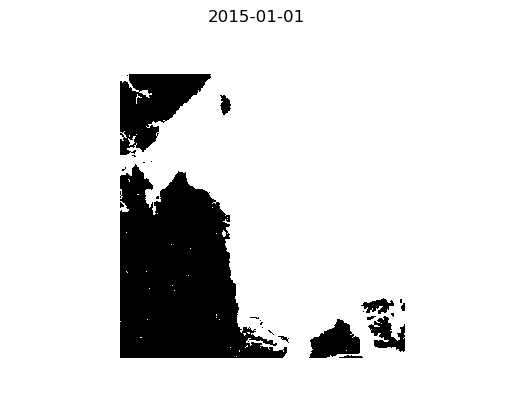

In [21]:
if file_type == "npy":
    plt.imshow(testPredict[0].reshape(2000, 2000), cmap=cmap, interpolation="nearest")
else:
    image_date = df.loc[0, "Date"]
    plt.imshow(
        converted_testPredict[0].reshape(480, 640, 4),
        cmap=cmap,
        interpolation="nearest",
    )
    plt.title(image_date)
plt.axis("off")
plt.show()

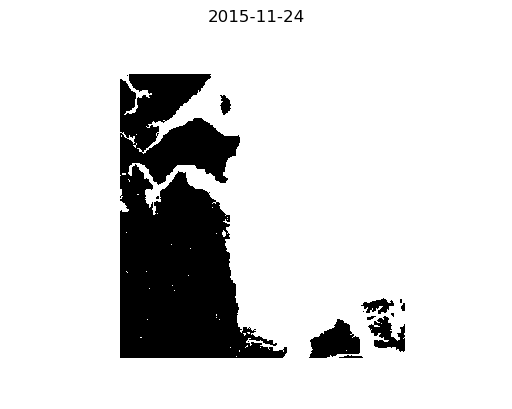

In [22]:
if file_type == "npy":
    plt.imshow(testY[0].reshape(2000, 2000), cmap=cmap, interpolation="nearest")
else:
    plt.imshow(
        converted_testY[0].reshape(480, 640, 4), cmap=cmap, interpolation="nearest"
    )
    image_date = df.loc[len(train) + len(val), "Date"]
    plt.title(image_date)
plt.axis("off")
plt.show()